In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
from lb2jpsil import lorentz
import random
from typing import Tuple
from scipy import optimize, integrate, stats
import time
import ROOT

Welcome to JupyROOT 6.24/06


# Create the PDF
You only need to this once, so it's commented.

In [2]:
#ROOT.RooClassFactory.makePdf("AngularDistribution", "ctheta,phi,sx,sz,alpha", "",
#                             "1+ alpha * (sx * sqrt(1-pow(ctheta,2)) * cos(phi) + sz * ctheta)"
#                            )

# Load the PDF

In [3]:
ROOT.gSystem.Load('libAngularDistribution.so')

0


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



# Unconvoluted PDF

In [4]:
ctheta = ROOT.RooRealVar("ctheta", "ctheta", 0., -1., 1.)
phi = ROOT.RooRealVar("phi", "phi", 0., -np.pi, np.pi)
g = ROOT.RooRealVar("g", "g", 1.226, 0., 1e2)

In [5]:
angular_pdf = ROOT.AngularDistribution("pdf", "pdf", ctheta, phi, g)

In [6]:
angular_pdf.evaluate()

0.551977425457729

In [7]:
data_noconv = angular_pdf.generate(ROOT.RooArgSet(ctheta, phi), 100000)
data_noconv.write("unconvoluted_test.dat")
df_noconv = pd.read_csv('unconvoluted_test.dat', sep=" ", header=None)
df_noconv.drop(columns=[2], inplace=True)
df_noconv.rename(columns={0: 'cos_theta', 1: 'phi'}, inplace=True)

[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[ctheta,phi]) using numeric integrator RooAdaptiveIntegratorND to calculate Int(ctheta,phi)
[#1] INFO:DataHandling -- RooDataSet::write(pdfData) writing ASCII file unconvoluted_test.dat


In [8]:
df_noconv

,cos_theta,phi
0,-0.092542,-1.748670
1,0.786748,1.515830
2,0.097034,-2.604970
3,-0.504857,-1.772200
4,0.826671,-1.061240
...,...,...
99995,-0.700661,0.933466
99996,0.723367,1.805950
99997,-0.509533,1.967210
99998,0.472264,2.378940


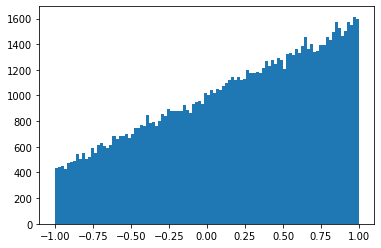

In [9]:
plt.hist(df_noconv['cos_theta'],bins=100)
plt.show()

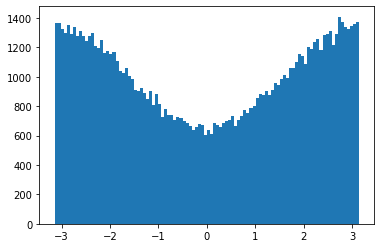

In [10]:
plt.hist(df_noconv['phi'],bins=100)
plt.show()

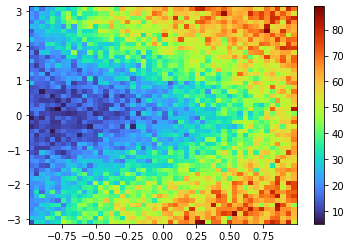

In [11]:
plt.hist2d(df_noconv['cos_theta'], df_noconv['phi'],bins=50, cmap='turbo')
plt.colorbar()
plt.show()

# $\theta$-convoluted PDF

In [12]:
theta_resolution = 0.097
#theta_resolution = 1e-3

In [13]:
sigma_theta = ROOT.RooFit.RooConst(theta_resolution)
mu_theta = ROOT.RooFit.RooConst(0.)

In [14]:
gaussian_theta = ROOT.RooGaussian("gaussian_theta", "gaussian_theta", ctheta, mu_theta, sigma_theta)

In [15]:
pdf_theta_conv = ROOT.RooFFTConvPdf("pdf_theta_conv", "pdf_theta_conv", ctheta, angular_pdf, gaussian_theta)

[#1] INFO:Caching -- Changing internal binning of variable 'ctheta' in FFT 'pdf_theta_conv' from 100 to 930 to improve the precision of the numerical FFT. This can be done manually by setting an additional binning named 'cache'.


In [16]:
pdf_theta_conv.bufferFraction()

0.1

In [17]:
#pdf_theta_conv.setBufferFraction(0.)
#pdf_theta_conv.bufferFraction()

In [18]:
pdf_theta_conv.bufferStrategy()

0

In [19]:
pdf_theta_conv.setBufferStrategy(2)
pdf_theta_conv.bufferStrategy()

2

In [20]:
tick = time.perf_counter()
data_theta_conv = pdf_theta_conv.generate(ROOT.RooArgSet(ctheta, phi), 10000)
#data_theta_conv = pdf_theta_conv.generate(ctheta, 100000)
tock = time.perf_counter()
print(tock - tick)
#data_theta_conv = pdf_theta_conv.generate(ctheta, 10000)

44.44670385681093
[#1] INFO:Eval -- RooRealVar::setRange(ctheta) new range named 'refrange_fft_pdf_theta_conv' created with bounds [-1,1]
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[ctheta]) using numeric integrator RooIntegrator1D to calculate Int(ctheta)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(pdf_theta_conv) creating new cache 0x8f4aef0 with pdf pdf_CONV_gaussian_theta_CACHE_Obs[ctheta]_NORM_ctheta_phi for nset (ctheta,phi) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_CONV_gaussian_theta_CACHE_Obs[ctheta]_NORM_ctheta_phi_Int[ctheta,phi]) using numeric integrator RooIntegrator1D to calculate Int(phi)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[ctheta]) using numeric integrator RooIntegrator1D to calculate Int(ctheta)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(pdf_theta_conv) creating new cache 0x8fdb240 with pdf pdf_CONV_gaussian_theta_CACHE_Obs[ctheta]_NORM_ctheta_phi for nset (ctheta,phi) with code 0
[#1] INFO:

In [21]:
data_theta_conv.write("theta_conv_test.dat")
df_theta_conv = pd.read_csv('theta_conv_test.dat', sep=" ", header=None)
df_theta_conv.drop(columns=[2], inplace=True)
#df_theta_conv.drop(columns=[1], inplace=True)
df_theta_conv.rename(columns={0: 'cos_theta', 1: 'phi'}, inplace=True)

[#1] INFO:DataHandling -- RooDataSet::write(pdf_theta_convData) writing ASCII file theta_conv_test.dat


In [22]:
df_theta_conv

,cos_theta,phi
0,0.953940,-3.132340
1,-0.720874,-1.996080
2,0.859159,2.362570
3,0.755553,0.854252
4,0.832146,1.148780
...,...,...
9995,0.380525,-1.674330
9996,0.873994,2.908630
9997,-0.172294,-3.078760
9998,0.034133,2.526630


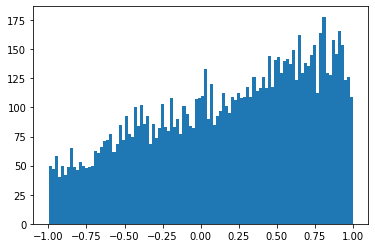

In [23]:
plt.hist(df_theta_conv['cos_theta'],bins=100)
plt.show()

In [24]:
#plt.hist(df_theta_conv['phi'],bins=100)
#plt.show()

In [25]:
#plt.hist2d(df_theta_conv['cos_theta'], df_theta_conv['phi'],bins=50, cmap='turbo')
#plt.xlim(-1,1)
#plt.ylim(-np.pi,np.pi)
#plt.colorbar()
#plt.show()

## Fit & plot

In [26]:
c = ROOT.TCanvas("rf101_basics", "rf101_basics", 800, 400)
c.cd()

In [27]:
ctheta_frame = ctheta.frame()

In [28]:
data_theta_conv.plotOn(ctheta_frame)

In [29]:
ctheta_frame.Draw()

In [30]:
c.Print("filename.pdf")

Info in <TCanvas::Print>: pdf file filename.pdf has been created


In [31]:
tick =time.perf_counter()

In [32]:
g.setVal(10.)

In [ ]:
pdf_theta_conv.fitTo(data_theta_conv)

In [ ]:
tock = time.perf_counter()
tock - tick

# $\phi$-convoluted PDF

In [ ]:
phi_resolution = 0.332
#phi_resolution = 1e-3

In [ ]:
sigma_phi = ROOT.RooFit.RooConst(phi_resolution)
mu_phi = ROOT.RooFit.RooConst(0.)

In [ ]:
gaussian_phi = ROOT.RooGaussian("gaussian_phi", "gaussian_phi", phi, mu_phi, sigma_phi)

In [ ]:
pdf_theta_phi_conv = ROOT.RooFFTConvPdf("pdf_theta_phi_conv", "pdf_theta_phi_conv", phi, angular_pdf, gaussian_phi)

In [ ]:
pdf_theta_phi_conv.setBufferStrategy(2)

In [ ]:
tick = time.perf_counter()
data_theta_phi_conv = pdf_theta_phi_conv.generate(ROOT.RooArgSet(ctheta, phi), 100000)
tock = time.perf_counter()
print(tock - tick)

In [ ]:
data_theta_phi_conv.write("theta_phi_conv_test.dat")
df_theta_phi_conv = pd.read_csv('theta_phi_conv_test.dat', sep=" ", header=None)
df_theta_phi_conv.drop(columns=[2], inplace=True)
df_theta_phi_conv.rename(columns={0: 'cos_theta', 1: 'phi'}, inplace=True)

In [ ]:
df_theta_phi_conv

In [ ]:
plt.hist(df_theta_phi_conv['cos_theta'],bins=100)
plt.show()

In [ ]:
plt.hist(df_theta_phi_conv['phi'],bins=100)
plt.show()

In [ ]:
plt.hist2d(df_theta_phi_conv['cos_theta'], df_theta_phi_conv['phi'],bins=50, cmap='turbo')
plt.xlim(-1,1)
plt.ylim(-np.pi,np.pi)
plt.colorbar()
plt.show()